#### When combining NDEs using CDF transforms, weigh each NDE using CV

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator
import popsed
popsed.set_matplotlib(style='JL', usetex=True, dpi=80)
from popsed import prior

In [4]:
## Load SuperSpeculator
wave = np.load('./train_sed_NMF/nmf_seds/fsps.wavelength.npy')
speculator = SuperSpeculator(
    speculators_dir=[f'./train_sed_NMF/best_emu/speculator_best_recon_model_NMF.emu_{i_bin}.pkl' for i_bin in range(0, 5)], 
    str_wbin=[
              '.w1000_2000',
              '.w2000_3600', 
              '.w3600_5500', 
              '.w5500_7410', 
              '.w7410_60000'],
    wavelength=wave, 
    params_name=['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh', 
                 'fburst', 'tburst', 'logzsol', 'dust1', 'dust2', 
                 'dust_index', 'redshift', 'logm'], 
    device='cuda')

noise = 'nsa'
noise_model_dir = './noise_model/nsa_noise_model_mag.npy'
filters = ['sdss_{0}0'.format(b) for b in 'ugriz']

In [5]:
def gen_truth(N_samples=5000):
    ncomp = 4
    priors = prior.load_priors([
            # Log stellar mass, in M_sun
            prior.GaussianPrior(10.5, 0.4, label='logm'),
            # flat dirichilet priors for SFH
            prior.TruncatedNormalPrior(0, 1, 0.5, 0.1), 
            prior.TruncatedNormalPrior(0, 1, 0.5, 0.1), 
            prior.TruncatedNormalPrior(0, 1, 0.5, 0.1), 
    #         prior.FlatDirichletPrior(ncomp, label='beta'),
            # uniform priors on the mass fraction of burst
            prior.TruncatedNormalPrior(0, 0.6, 0.2, 0.1, label='fburst'),
            # uniform priors on star-burst lookback time
            prior.TruncatedNormalPrior(1e-2, 13.27, 5, 1.5, label='tburst'),
            # uniform priors on log-metallicity, absolute Z
            prior.TruncatedNormalPrior(-2.6, 0.3, -1, 0.3, label='logzsol'),
            # uniform priors on dust1
            prior.TruncatedNormalPrior(0., 3., 0.6, 0.3, label='dust1'),
            # uniform priors on dust2
            prior.TruncatedNormalPrior(0., 3., 0.6, 0.3, label='dust2'),
            # uniform priors on dust_index
            prior.TruncatedNormalPrior(-3., 1., -1, 0.3, label='dust_index'),
            # uniformly sample redshift
            prior.TruncatedNormalPrior(0., 1.5, 0.08, 0.05, label='redshift')
        ])
    
    _thetas_unt = np.array([priors.sample() for i in range(N_samples)])
    _thetas = np.hstack([_thetas_unt[:, 0:1], 
               prior.FlatDirichletPrior(4).transform(_thetas_unt[:, 1:4]), 
               _thetas_unt[:, 4:]])
    
    return _thetas, _thetas_unt

In [6]:
from popsed.nde import transform_nmf_params, inverse_transform_nmf_params

In [7]:
_thetas, _thetas_unt = gen_truth(N_samples=5000)

_prior_NDE = speculator.bounds.copy()
_prior_NDE[-2] = np.array([0., 0.3])
_prior_NDE[-1] = np.array([8, 12])

Y_truth = np.hstack([_thetas_unt[:, 1:], # params taken by emulator, including redshift (for t_age)
                     _thetas_unt[:, 0:1], # stellar mass
                    ])
Y_truth = torch.Tensor(Y_truth).to('cuda')
Y_truth_tr = transform_nmf_params(Y_truth, _prior_NDE).to('cpu')

X_data = speculator._predict_mag_with_mass_redshift_batch(Y_truth, filterset=filters,
                                                          noise=noise,
                                                          noise_model_dir=noise_model_dir)
flag = ~(torch.isnan(X_data).any(dim=1) | torch.isinf(X_data).any(dim=1))
flag = flag & (~torch.isnan(Y_truth_tr).any(axis=1))
flags = [((Y_truth[:, i] < speculator.bounds[i, 1]) & (Y_truth[:, i] > speculator.bounds[i, 0])).cpu().numpy()
         for i in range(len(speculator.bounds))]
flag = flag.cpu().numpy() & np.array(flags).all(axis=0)
print('Number of bad photometry:', np.sum(~flag))
X_data = X_data[flag].detach()
Y_truth = Y_truth[flag]
Y_truth_tr = Y_truth_tr[flag]

Number of bad photometry: 50


In [136]:
nde_dir = './NDE/NMF/nde_theta_NMF_CDF_sdss_noise_blur1e-3/'
filelist = os.listdir(nde_dir)

filelist = [file for file in filelist if 'nde_theta_best' in file]
# filelist = ['nde_theta_best_loss_nsf_20.pkl',
#             'nde_theta_best_loss_nsf_31.pkl',
#             'nde_theta_best_loss_nsf_25.pkl', 
#             'nde_theta_best_loss_nsf_35.pkl']

In [137]:
len(filelist)

20

In [138]:
# NDE = pickle.load(open('./NDE/NMF/nde_theta_NMF_CDF_sdss_noise_lowblur/nde_theta_best_loss_nsf_0.pkl', 'rb'))

In [139]:
# This is slow
NDE_list = []
for file in filelist:
    try:
        NDE = pickle.load(open(os.path.join(nde_dir, file), 'rb'))
        del NDE.X
        del NDE.X_vali
        del NDE.batch_theta
        NDE_list.append(NDE)
#         if np.mean(NDE.vali_loss_history[-20:]) < 0.1:
#             NDE_list.append(NDE)
# #             pass
#         else:
#             print('Poor vali loss for', file)
# #             print('Remove', file)
    except Exception as e:
        print(file, e)
        continue

In [140]:
len(NDE_list)

20

In [141]:
### score for each model is vali_loss

In [142]:
vali_loss = np.array([np.mean(NDE.vali_loss_history[-20:]) for NDE in NDE_list])
vali_loss

array([0.08795928, 0.09081189, 0.08997485, 0.08930687, 0.08921031,
       0.0900616 , 0.09020156, 0.09233   , 0.08821206, 0.08934133,
       0.09082119, 0.08797682, 0.09091279, 0.09154456, 0.09415707,
       0.09541028, 0.09014556, 0.09044006, 0.09105527, 0.09002484])

In [143]:
score = np.min(vali_loss) / vali_loss
score

array([1.        , 0.96858769, 0.97759847, 0.98491054, 0.98597657,
       0.97665679, 0.97514141, 0.9526619 , 0.99713438, 0.98453059,
       0.96848852, 0.99980063, 0.96751271, 0.96083559, 0.93417598,
       0.92190567, 0.97574721, 0.9725698 , 0.96599873, 0.97705559])

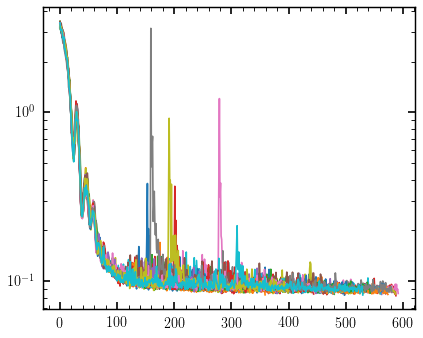

In [144]:
[plt.plot(NDE.vali_loss_history) for NDE in NDE_list]
plt.yscale('log')

In [145]:
torch.cuda.empty_cache()

### Show each NDE

In [146]:
_samples_unt = []
_samples = []
for NDE in [NDE_list[i] for i in np.argsort(vali_loss)[:]]:
    _samp = inverse_transform_nmf_params(NDE.sample(1200), _prior_NDE).cpu().detach().numpy()
    _samples_unt.append(_samp)
    _samples.append(np.hstack([_samp[:, -1:], 
                   prior.FlatDirichletPrior(4).transform(_samp[:, :3]), 
                   _samp[:, 3:-1]]))
_samples_unt = np.dstack(_samples_unt)
_samples = np.dstack(_samples)

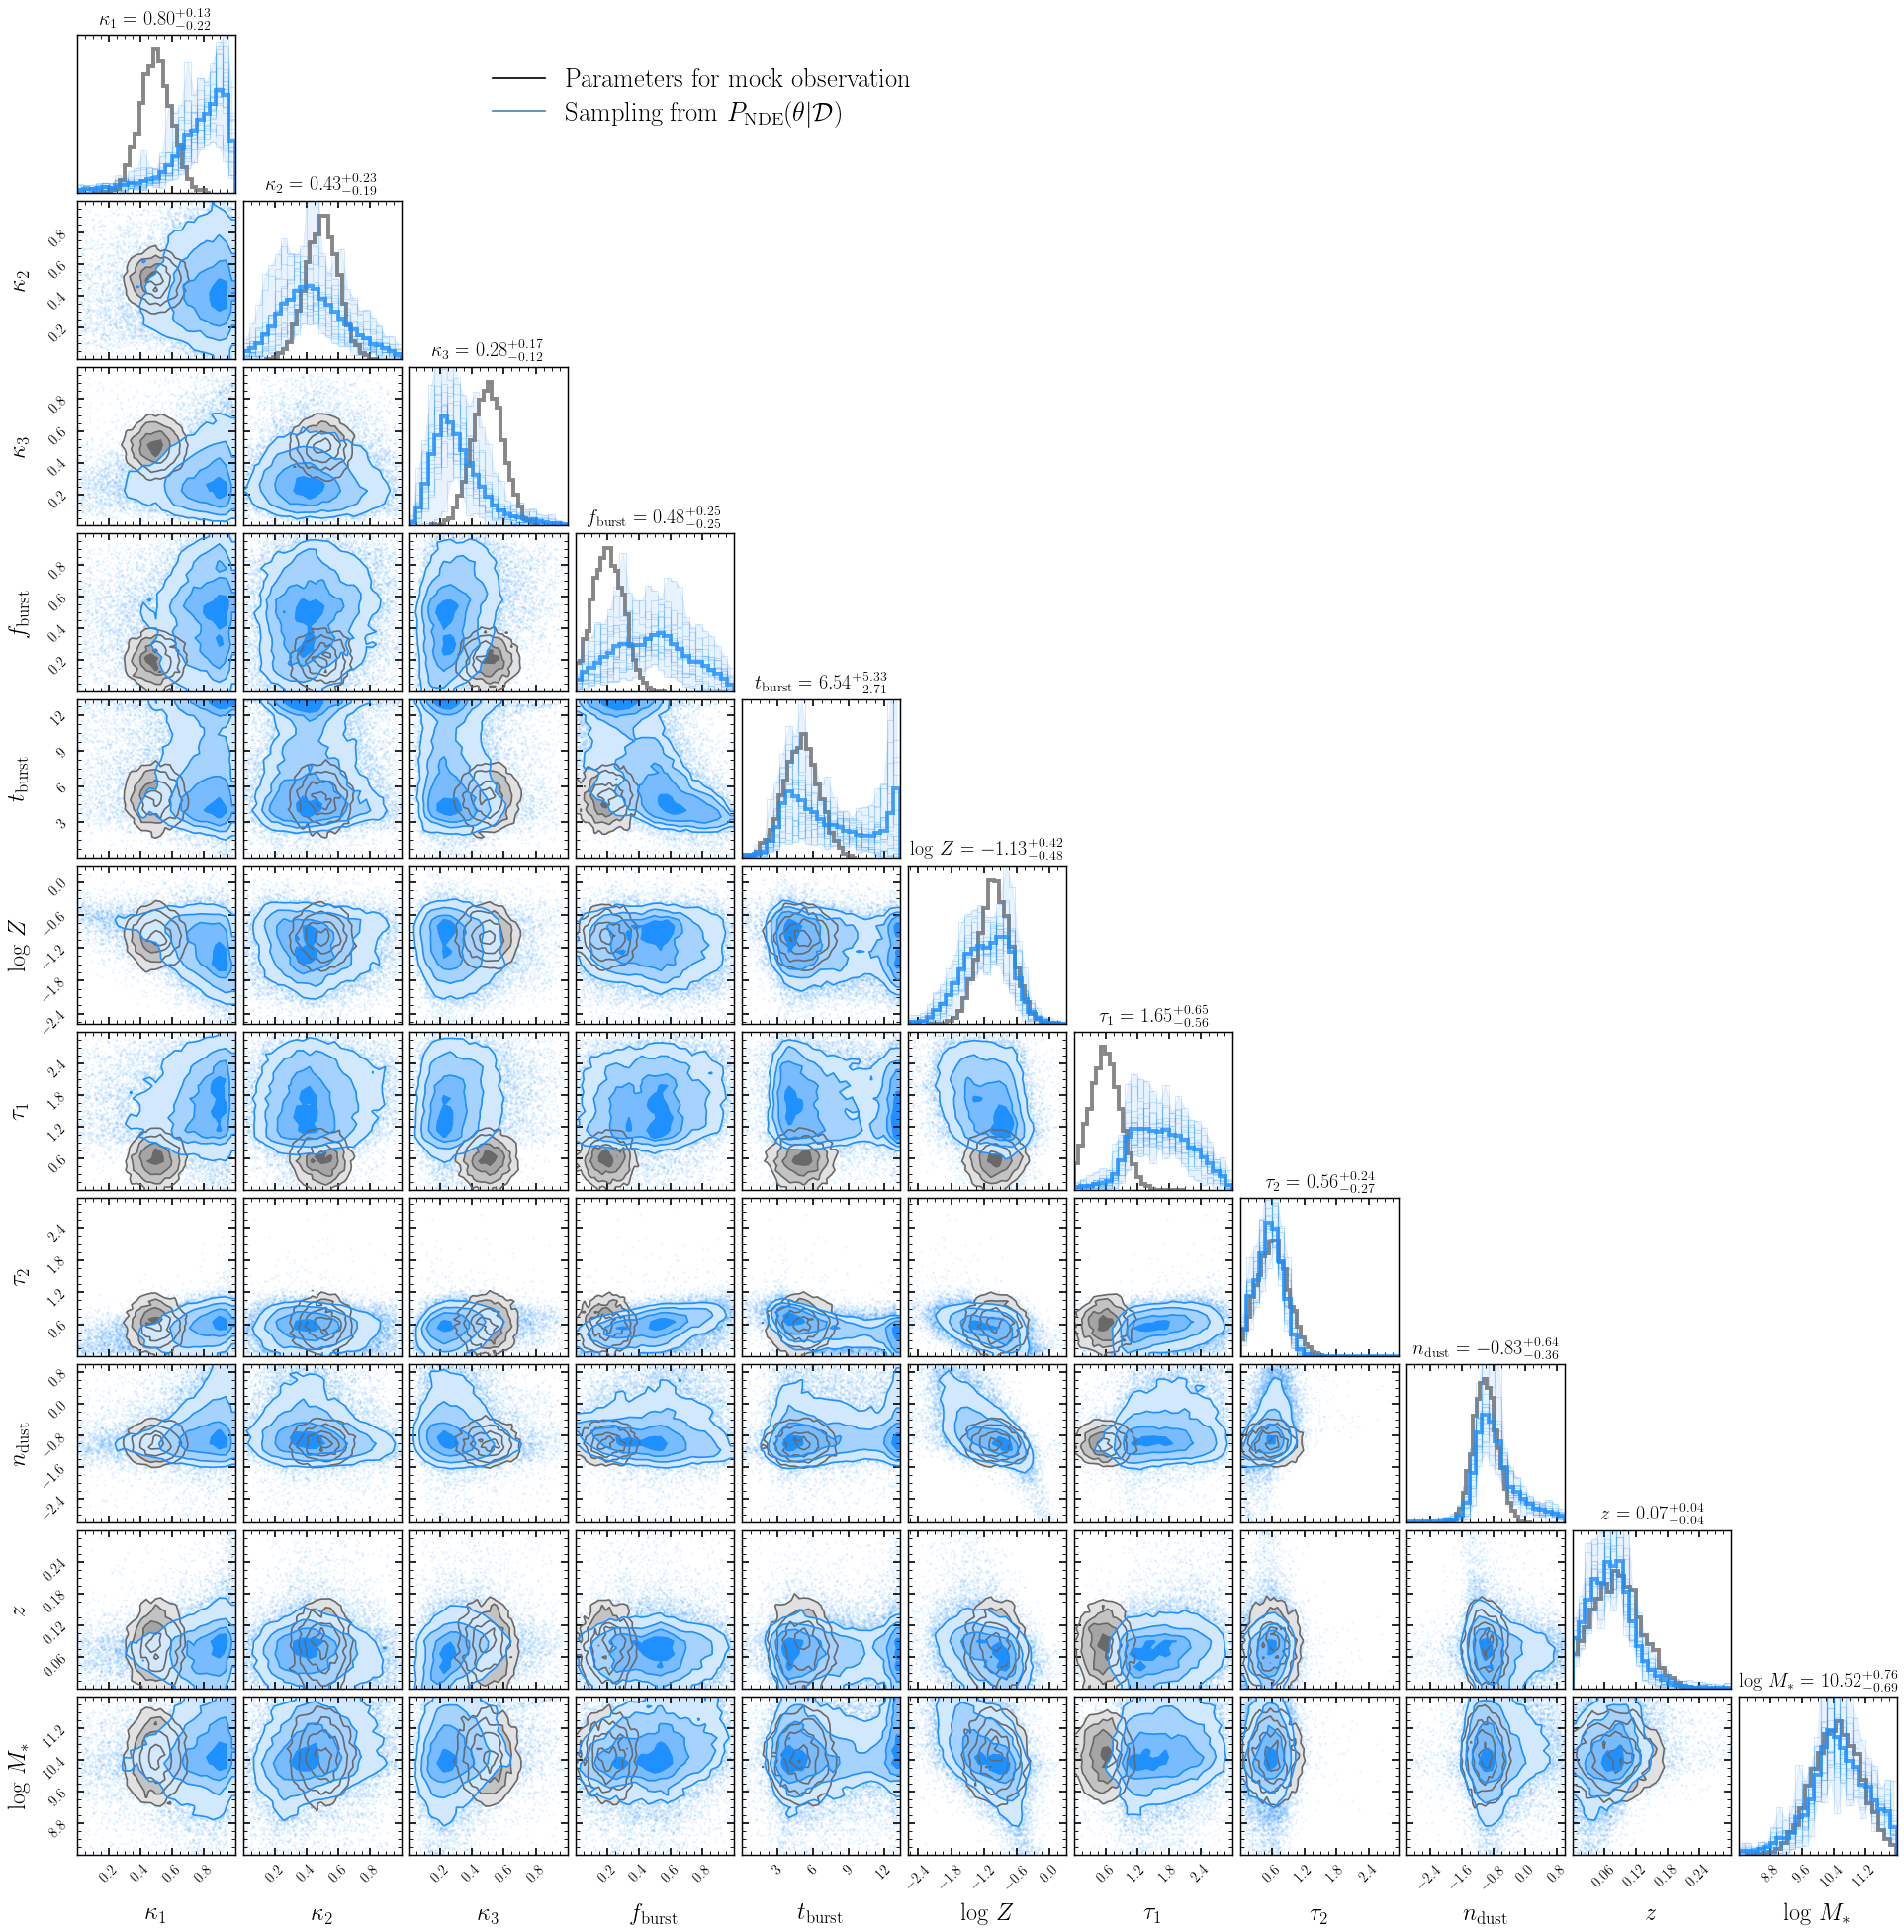

In [147]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Parameters for mock observation')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Sampling from $P_{\mathrm{NDE}}(\theta|\mathcal{D})$')

labels = [
    r'$\kappa_{1}$',
    r'$\kappa_{2}$',
    r'$\kappa_{3}$',
    r'$f_{\mathrm{burst}}$',
    r'$t_{\mathrm{burst}}$',
    r'$\log\,Z$',
    r'$\tau_1$',
    r'$\tau_2$',
    r'$n_{\mathrm{dust}}$',
    r'$z$',
    r'$\log\,M_*$',
    ]
# labels = [key.replace('_', '\_') for key in speculator.params_name]

figure = corner.corner(
    Y_truth.cpu().detach().numpy(),
    color='dimgray',
    labels=labels,
    bins=25,
    smooth=.5,
    fill_contours=True,
    show_titles=True,
    title_kwargs={'fontsize': 18},
    label_kwargs={'fontsize': 22},
    hist_kwargs={'density': True},
    plot_datapoints=False
    )

nf_plot = corner.corner(
    _samples_unt,
    fig=figure,
    labels=labels,
    color='dodgerblue',
    bins=25,
    smooth=.5,
    fill_contours=True,
    show_titles=True,
    title_kwargs={'fontsize': 18},
    label_kwargs={'fontsize': 22},
    hist_kwargs={'density': True, 'lw': 1},
    plot_datapoints=True
    )

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], 
          fontsize=24, 
          bbox_to_anchor=(0., 1.0, 1.3, .0))

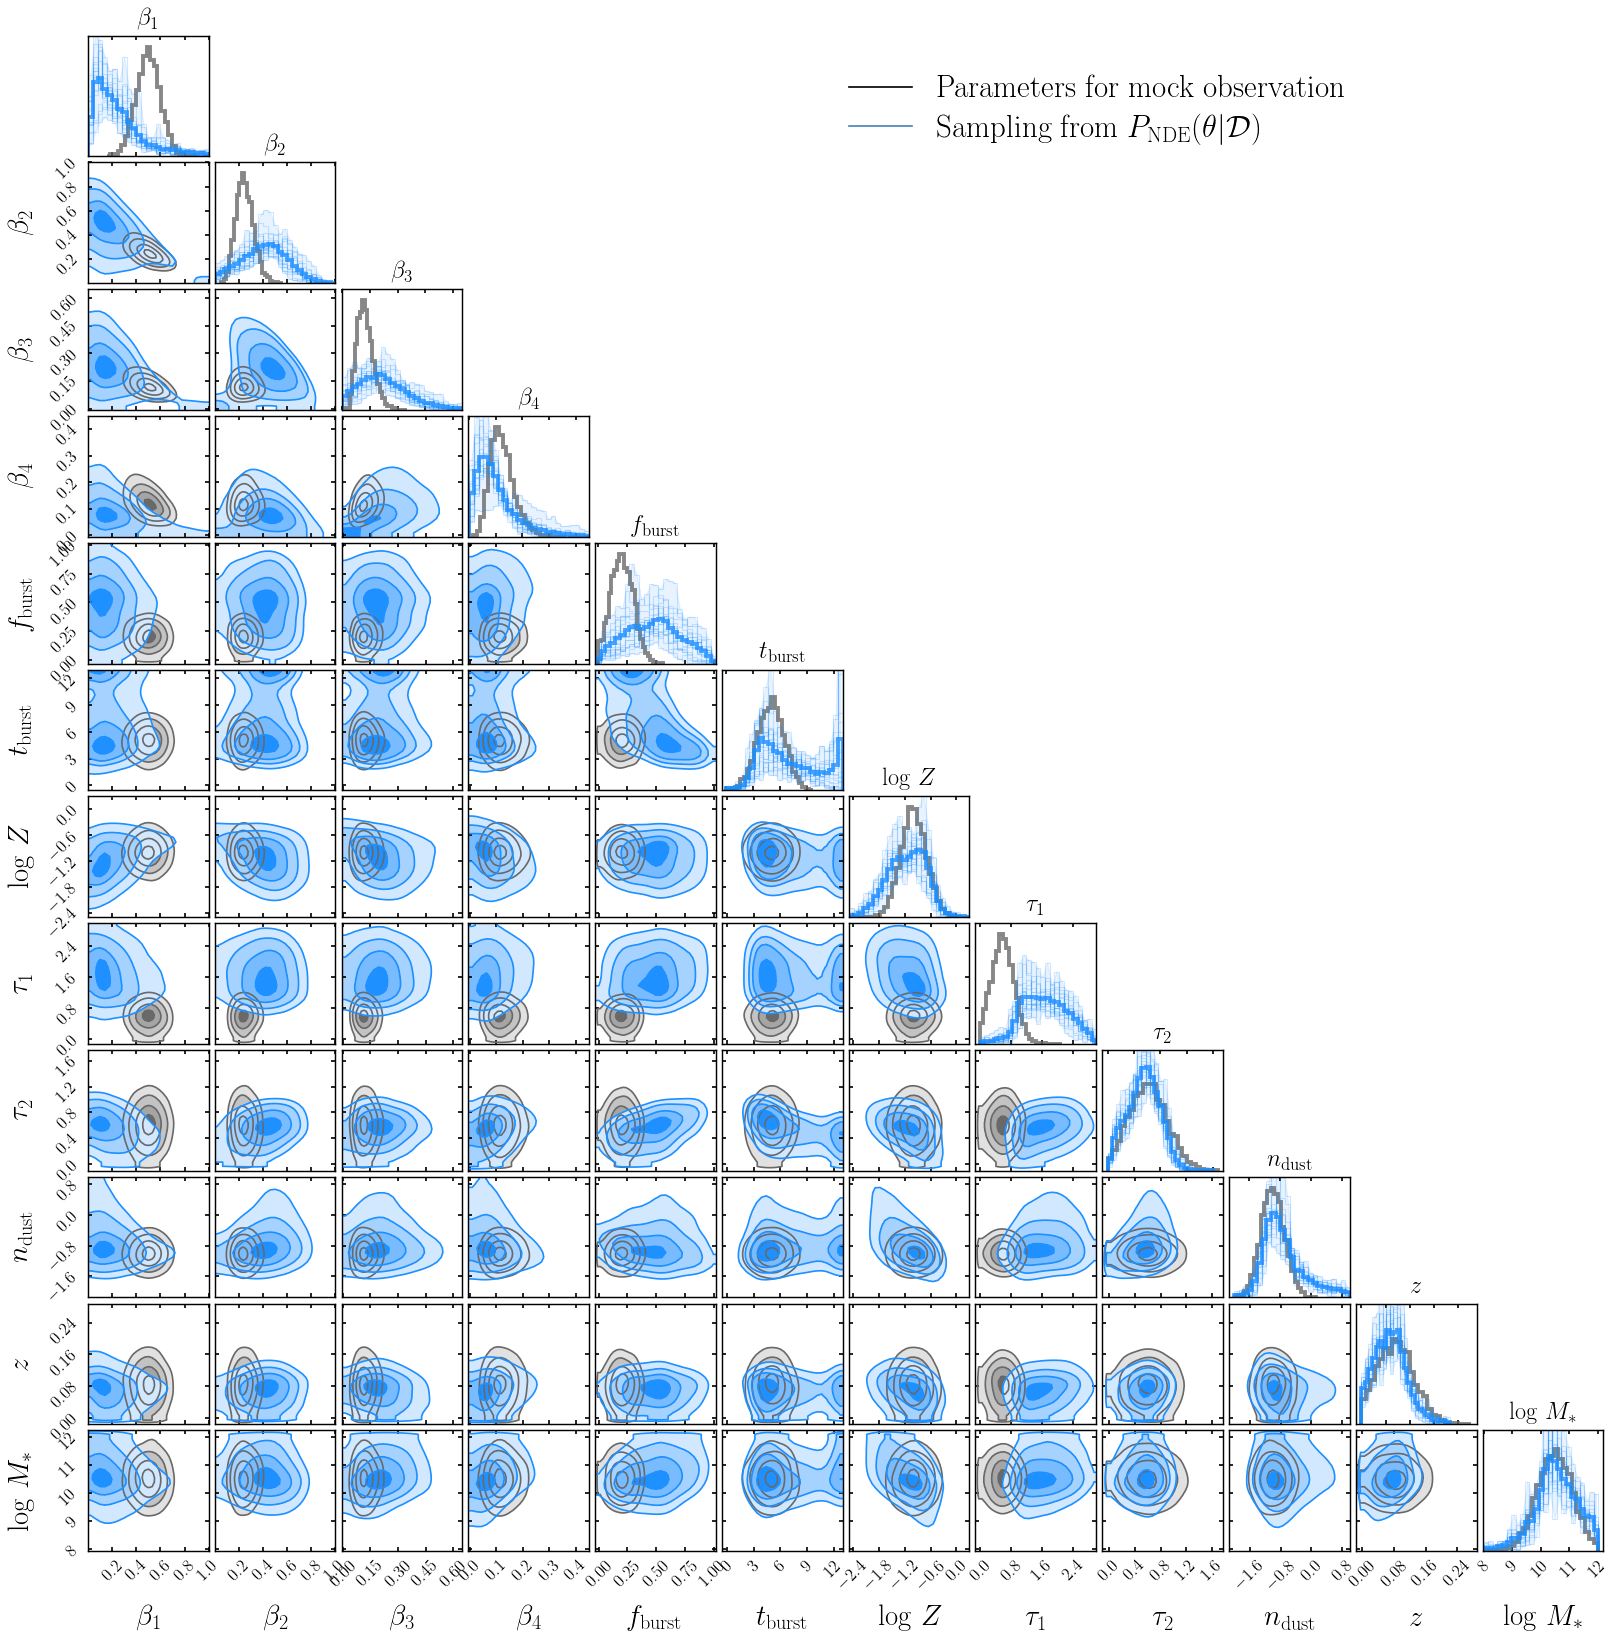

In [148]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Parameters for mock observation')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Sampling from $P_{\mathrm{NDE}}(\theta|\mathcal{D})$')

labels = [
    r'$\beta_{1}$',
    r'$\beta_{2}$',
    r'$\beta_{3}$',
    r'$\beta_{4}$',
    r'$f_{\mathrm{burst}}$',
    r'$t_{\mathrm{burst}}$',
    r'$\log\,Z$',
    r'$\tau_1$',
    r'$\tau_2$',
    r'$n_{\mathrm{dust}}$',
    r'$z$',
    r'$\log\,M_*$',
    ]

# Distribution of beta coeffs
y_truth_trans = np.hstack([_thetas[:, 1:], # params taken by emulator, including redshift (for t_age)
                           _thetas[:, 0:1], # stellar mass
                    ])
y_truth_trans = y_truth_trans[flag]

figure, axes = plt.subplots(12, 12, figsize=(20, 20))
figure = corner.corner(
    y_truth_trans,
    fig=figure,
    color='dimgray',
    labels=labels,
    bins=25,
    smooth=1.5,
    fill_contours=True,
    show_titles=True,
    title_fmt=None,
    title_kwargs={'fontsize': 22},
    label_kwargs={'fontsize': 26},
    labelpad=0.15,
    hist_kwargs={'density': True},
    plot_datapoints=False
    )

y_truth_trans = np.hstack([_samples[:, 1:], # params taken by emulator, including redshift (for t_age)
                           _samples[:, 0:1], # stellar mass
                    ])

nf_plot = corner.corner(
    y_truth_trans,
    fig=figure,
    color='dodgerblue',
    labels=labels,
    range=[[0, 1], [0, 1], [0., 0.65], [0, 0.45], [-0.02, 1.02], [0, 13], 
           [-2.5, 0.3], [0, 3], [0, 1.6], [-2, 1], [0, 0.22], [8, 12]],
    bins=25,
    smooth=1.5,
    fill_contours=True,
    show_titles=False,
    title_kwargs={'fontsize': 18},
    label_kwargs={'fontsize': 26},
    labelpad=0.15,
    hist_kwargs={'density': True, 'lw': 1},
    plot_datapoints=False
    )

for ax in figure.get_axes():
    ax.tick_params(labelsize=15, length=4)
    ax.minorticks_off()

ax = figure.get_axes()[9]
ax.legend(handles=[k_line, b_line], 
          fontsize=28, 
          bbox_to_anchor=(0., 1.0, 1.3, .0))

# plt.savefig('/home/jiaxuanl/Research/popsed/figure/P_theta.png', dpi=100, bbox_inches='tight') # slow

In [23]:
# del _samples
# import gc
# gc.collect()

0 17100
>30 0


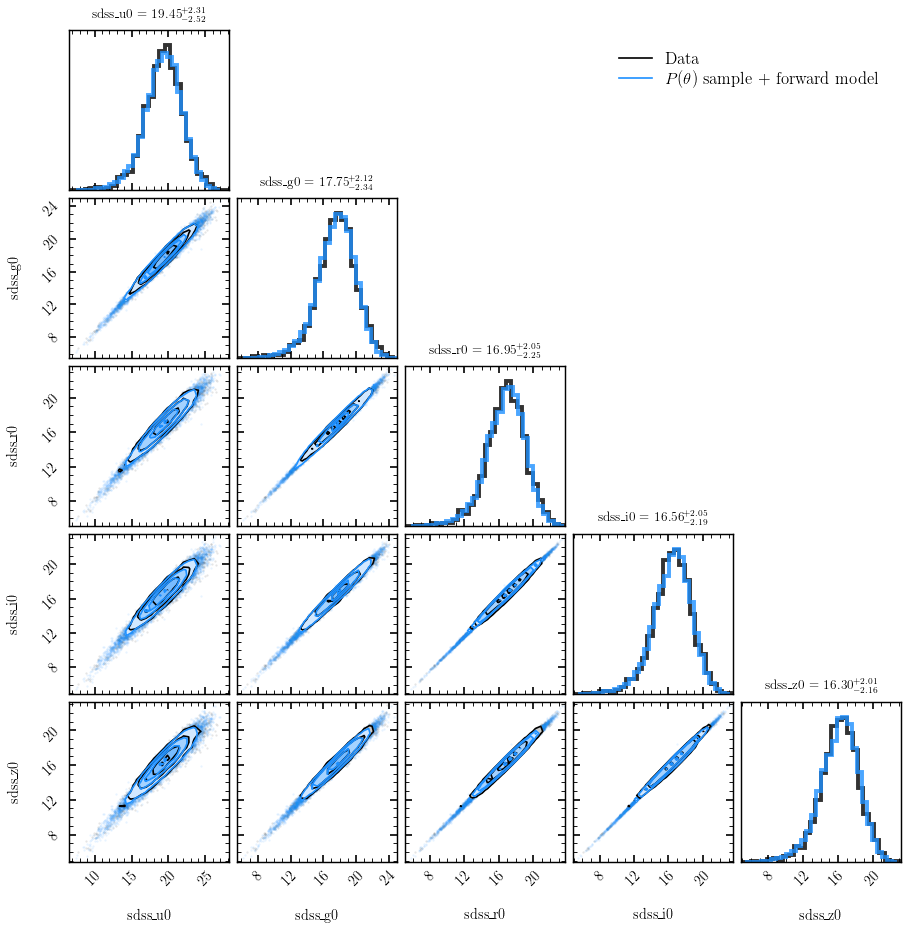

In [42]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = [filt.replace('_', '\_') for filt in filters]

figure = corner.corner(X_data.cpu().detach().numpy(), 
                       color='k', labels=labels, bins=30,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.4, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

mags = speculator._predict_mag_with_mass_redshift(_samples_unt.swapaxes(0, 1).reshape(11, -1).T,
                                                  filterset=filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>30', np.any(mags > 30, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 30, axis=1)]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=30,
                        #range=[[14, 25]] * 5,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [34]:
torch.cuda.empty_cache()

In [35]:
# sample the initial setups
_init_sample = []

for NDE in [NDE_list[i] for i in np.argsort(vali_loss)]:
    _mean = NDE.mean_init
    _stds = NDE.initial_pos['std']
    _init_sample.append(np.random.normal(_mean, _stds, size=(1000, 11)))
    
_init_sample = np.array(_init_sample).reshape(-1, 11)

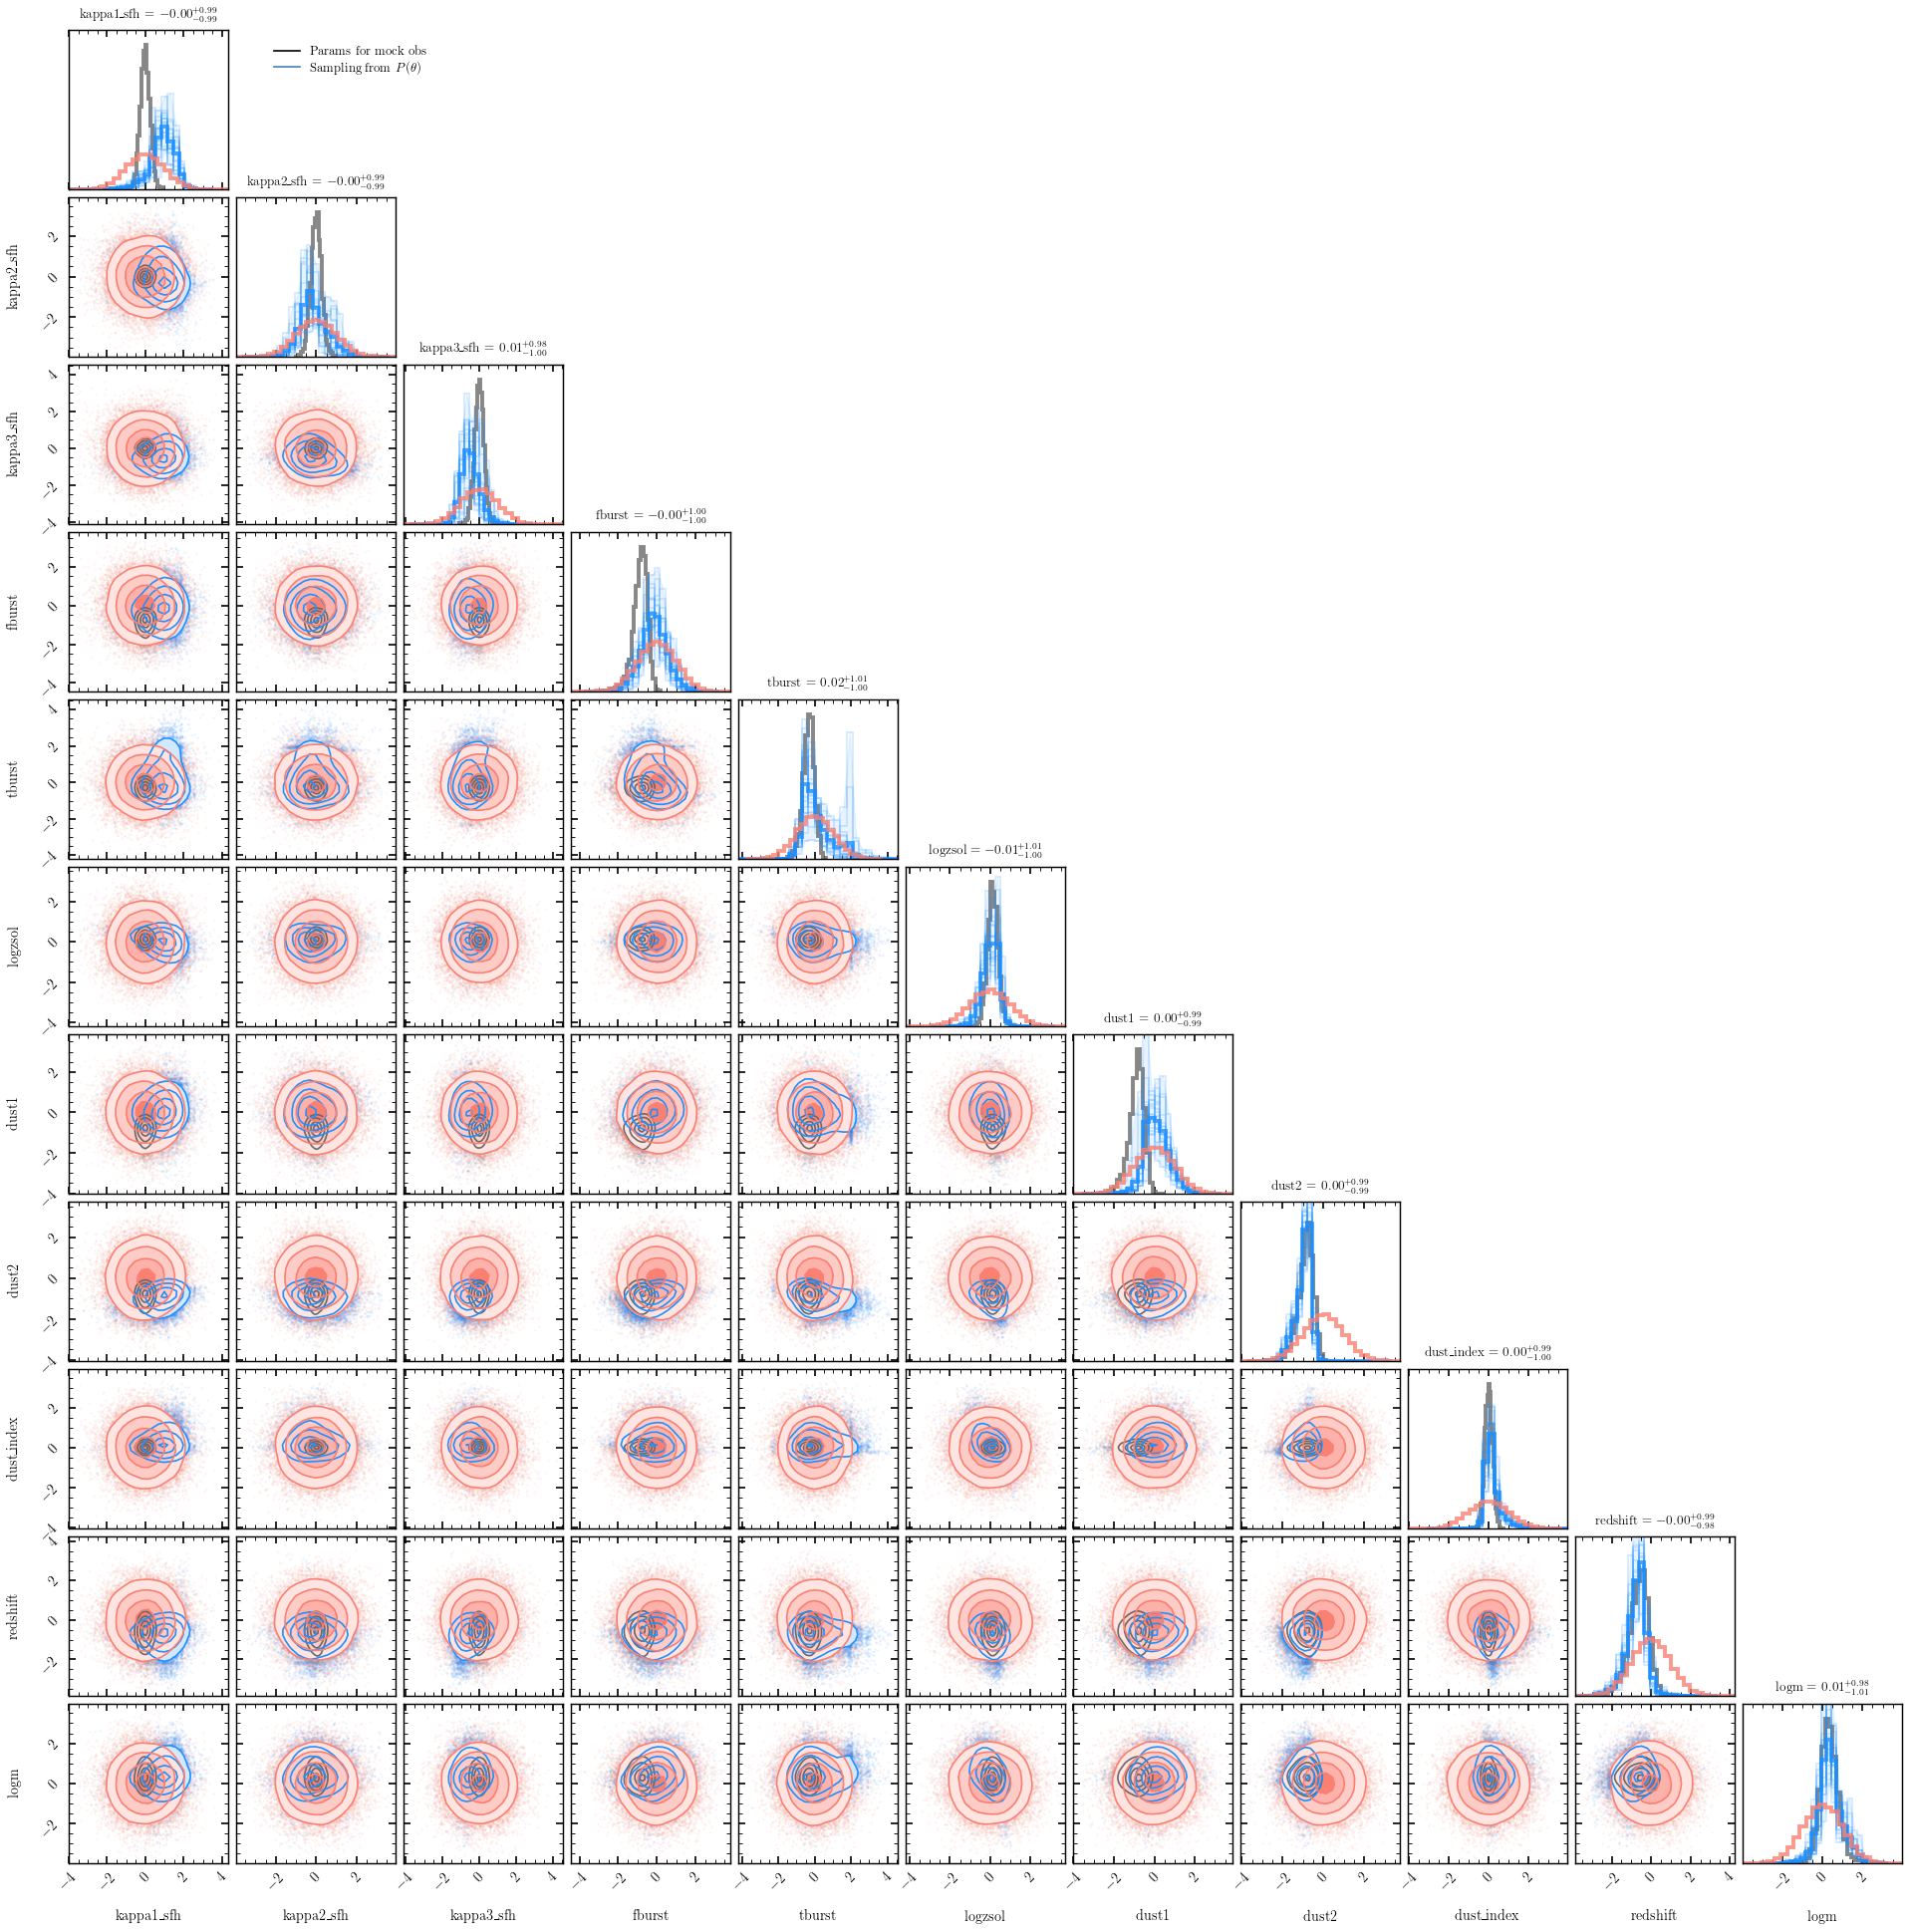

In [36]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Sampling from $P(\theta)$')

labels = [key.replace('_', '\_') for key in speculator.params_name]

figure = corner.corner(transform_nmf_params(Y_truth, _prior_NDE).cpu().detach().numpy(), 
                       color='dimgray', labels=labels, bins=25,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=1, fill_contours=True,
                       show_titles=True, title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

nf_plot = corner.corner(transform_nmf_params(torch.Tensor(_samples_unt).to('cuda'), _prior_NDE
                                            ).cpu().detach().numpy(), 
                  fig=figure, labels=labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=1, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

_ = corner.corner(_init_sample, 
                   fig=figure, color='salmon', alpha=0.1, labels=labels, bins=25,
                   #quantiles=[0.16, 0.5, 0.84], 
                   smooth=0.8, fill_contours=True,
                   show_titles=True, 
                   hist_kwargs={'density': True, 'lw': 0.5}, 
                   title_kwargs={"fontsize": 12},
                   plot_datapoints=True)

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))